## FMA genre classification using MLPClassifier


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import IPython.display as ipd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV)

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from collections import Counter
import utils

#### Again we use medium+small to get a larger and more representative set of training exemplars

Note: will be unbalanced

In [2]:
RANDOM_STATE = 53

(features, tracks) = utils.load_features()

small = tracks[('set', 'subset')] == 'small'
medium = tracks[('set', 'subset')].isin(['small','medium'])
X = features[medium]
y = tracks[medium][('track','genre_top')]

prune = ~y.isin(['Spoken','Blues','Easy Listening'])
y = y[prune]
X = X[prune]
print(X.shape, y.shape)
Counter(y)

(24787, 518) (24787,)


Counter({'Hip-Hop': 2201,
         'Pop': 1186,
         'Rock': 7103,
         'Folk': 1519,
         'Experimental': 2251,
         'Jazz': 384,
         'Electronic': 6314,
         'International': 1018,
         'Soul-RnB': 154,
         'Country': 178,
         'Classical': 619,
         'Old-Time / Historic': 510,
         'Instrumental': 1350})

### Create test and training sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
scaler = MinMaxScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Train with defaults

* overall accuracy is not bad
* high performance of overrepresented Electroinic and Rock masks poor performance on other genres
* at the same time the less performant datasets are the ones we would expect from our dimensionality reduction inspection


                     precision    recall  f1-score   support

          Classical       0.74      0.83      0.78       124
            Country       0.56      0.14      0.23        35
         Electronic       0.66      0.85      0.74      1263
       Experimental       0.53      0.42      0.47       450
               Folk       0.61      0.67      0.64       304
            Hip-Hop       0.79      0.60      0.68       440
       Instrumental       0.54      0.43      0.48       270
      International       0.53      0.59      0.56       204
               Jazz       0.86      0.25      0.38        77
Old-Time / Historic       0.99      0.94      0.96       102
                Pop       0.30      0.11      0.17       237
               Rock       0.79      0.84      0.81      1421
           Soul-RnB       0.75      0.10      0.17        31

           accuracy                           0.69      4958
          macro avg       0.67      0.52      0.54      4958
       weighted avg   

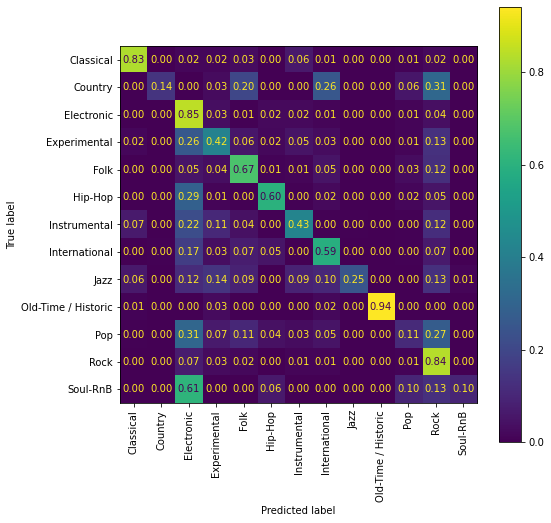

In [4]:
cl1 = MLPClassifier(max_iter=500, random_state=RANDOM_STATE)
cl1.fit(X_train, y_train)
utils.run_classifier_and_report(cl1, X_test, y_test)

#### Can we address the imbalance with up and down sampling?

* MLPClassifier does not support class_weight 
* We can try upsampling and downsampling the data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
scaler = MinMaxScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# now resample the training set

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample all genres < 500 to 500
strategy = {}
for genre, count in Counter(y_train).items():
    if (count < 500):
        strategy[genre] = 500
over = RandomOverSampler(sampling_strategy=strategy, random_state=RANDOM_STATE)
X_train, y_train = over.fit_resample(X_train, y_train)

# undersample all genres > 3500 to 3500
strategy = {}
for genre, count in Counter(y).items():
    if (count > 3500):
        strategy[genre] = 3500
under = RandomUnderSampler(sampling_strategy=strategy, random_state=RANDOM_STATE)
X_train, y_train = under.fit_resample(X_train, y_train)

Counter(y_train)


Counter({'Classical': 500,
         'Country': 500,
         'Electronic': 3500,
         'Experimental': 1801,
         'Folk': 1215,
         'Hip-Hop': 1761,
         'Instrumental': 1080,
         'International': 814,
         'Jazz': 500,
         'Old-Time / Historic': 500,
         'Pop': 949,
         'Rock': 3500,
         'Soul-RnB': 500})

                     precision    recall  f1-score   support

          Classical       0.79      0.77      0.78       124
            Country       0.19      0.63      0.29        35
         Electronic       0.67      0.79      0.72      1263
       Experimental       0.48      0.43      0.45       450
               Folk       0.66      0.60      0.63       304
            Hip-Hop       0.66      0.67      0.67       440
       Instrumental       0.42      0.59      0.49       270
      International       0.57      0.56      0.57       204
               Jazz       0.45      0.34      0.39        77
Old-Time / Historic       0.98      0.94      0.96       102
                Pop       0.33      0.14      0.20       237
               Rock       0.87      0.74      0.80      1421
           Soul-RnB       0.24      0.32      0.27        31

           accuracy                           0.66      4958
          macro avg       0.56      0.58      0.56      4958
       weighted avg   

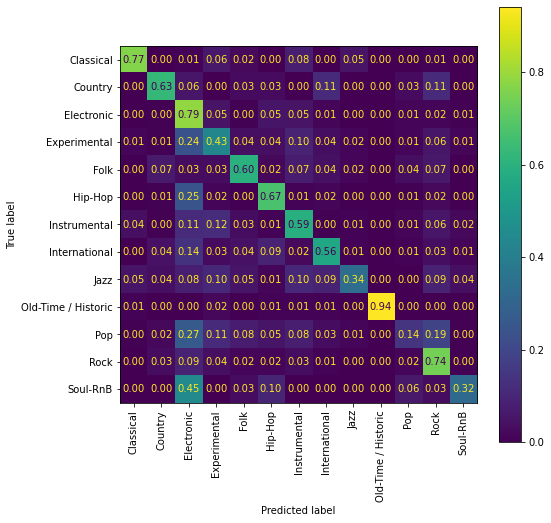

In [6]:
cl2 = MLPClassifier(max_iter=500,  random_state=RANDOM_STATE)
cl2.fit(X_train, y_train)
utils.run_classifier_and_report(cl2, X_test, y_test)

#### observations
* accuracy declined a little, but the macro average is a little better.
* we see that Pop is still a hugely problematic category

#### can we improve the imbalance with more sophisticated sampling?
* try some more sophisticated techniques for unbalanced data.
* SMOTE will synthesize data by interpolating features of KNN-selected neighbros


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
scaler = MinMaxScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# now resample the training set

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample all genres < 500 to 500
strategy = {}
for genre, count in Counter(y_train).items():
    if (count < 500):
        strategy[genre] = 500
over = SMOTE(sampling_strategy=strategy)
X_train, y_train = over.fit_resample(X_train, y_train)

# undersample all genres > 3500 to 3500
strategy = {}
for genre, count in Counter(y).items():
    if (count > 3500):
        strategy[genre] = 3500
under = RandomUnderSampler(sampling_strategy=strategy)
X_train, y_train = under.fit_resample(X_train, y_train)

Counter(y_train)

Counter({'Classical': 500,
         'Country': 500,
         'Electronic': 3500,
         'Experimental': 1801,
         'Folk': 1215,
         'Hip-Hop': 1761,
         'Instrumental': 1080,
         'International': 814,
         'Jazz': 500,
         'Old-Time / Historic': 500,
         'Pop': 949,
         'Rock': 3500,
         'Soul-RnB': 500})

                     precision    recall  f1-score   support

          Classical       0.73      0.84      0.78       124
            Country       0.23      0.57      0.33        35
         Electronic       0.77      0.65      0.70      1263
       Experimental       0.51      0.38      0.43       450
               Folk       0.62      0.67      0.64       304
            Hip-Hop       0.54      0.79      0.65       440
       Instrumental       0.45      0.50      0.47       270
      International       0.60      0.51      0.55       204
               Jazz       0.51      0.42      0.46        77
Old-Time / Historic       0.97      0.97      0.97       102
                Pop       0.26      0.09      0.13       237
               Rock       0.76      0.85      0.80      1421
           Soul-RnB       0.26      0.32      0.29        31

           accuracy                           0.66      4958
          macro avg       0.55      0.58      0.55      4958
       weighted avg   

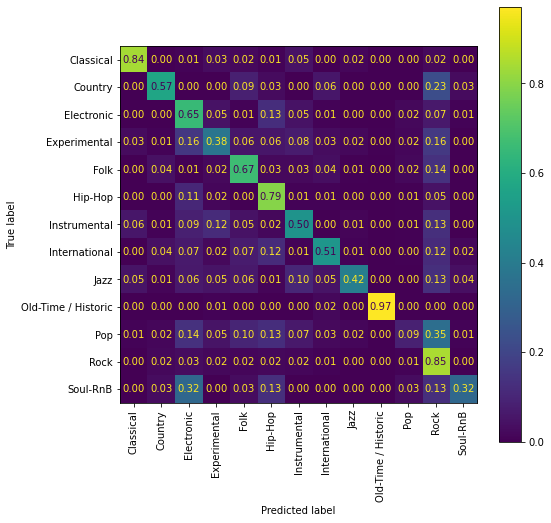

In [8]:
cl3 = MLPClassifier(max_iter=500,  random_state=RANDOM_STATE)
cl3.fit(X_train, y_train)
utils.run_classifier_and_report(cl3, X_test, y_test)

#### Simple tuning attempt with GridSearch - do more nodes or layers help?

NOTE: VERY VERY SLOW!

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'solver': 'adam'}
                     precision    recall  f1-score   support

          Classical       0.72      0.88      0.79       124
            Country       0.46      0.54      0.50        35
         Electronic       0.73      0.74      0.74      1263
       Experimental       0.46      0.50      0.48       450
               Folk       0.59      0.69      0.64       304
            Hip-Hop       0.65      0.72      0.69       440
       Instrumental       0.50      0.37      0.43       270
      International       0.62      0.56      0.59       204
               Jazz       0.49      0.55      0.52        77
Old-Time / Historic       0.98      0.95      0.97       102
                Pop       0.24      0.23      0.23       237
               Rock       0.82      0.77      0.80      1421
           Soul-RnB       0.57      0.42      0.48        31

           accuracy          

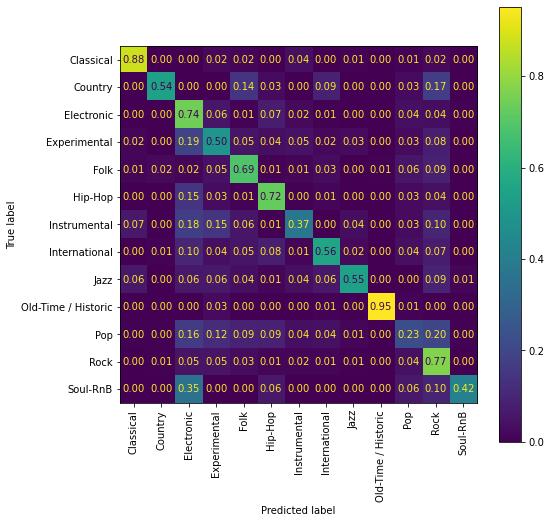

In [9]:
params = {
    'hidden_layer_sizes': [(50,),(100,),(200,),(300,),(400,),(100,50)],
    'alpha': [0.0001, 0.001, .01, .1],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

cl4 = HalvingGridSearchCV(MLPClassifier(max_iter=1000), 
                         params, 
                         scoring='f1_macro', 
                         n_jobs=-1, random_state=RANDOM_STATE)
cl4.fit(X_train, y_train)
print(cl4.best_params_)
utils.run_classifier_and_report(cl4.best_estimator_, X_test, y_test)

# (400,), alpha=0.01, learning rate constant

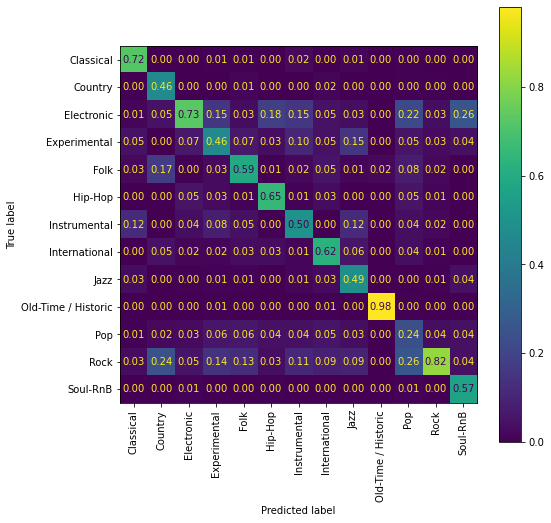

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(cl4.best_estimator_, X_test, y_test,ax=ax,xticks_rotation='vertical',values_format='0.2f', normalize='pred')

#### 400 nodes on random upsample/downsample

C:\Users\orovi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                     precision    recall  f1-score   support

          Classical       0.71      0.85      0.77       124
            Country       0.54      0.40      0.46        35
         Electronic       0.77      0.70      0.73      1263
       Experimental       0.54      0.43      0.48       450
               Folk       0.60      0.69      0.64       304
            Hip-Hop       0.69      0.69      0.69       440
       Instrumental       0.50      0.52      0.51       270
      International       0.49      0.66      0.56       204
               Jazz       0.39      0.57      0.47        77
Old-Time / Historic       0.97      0.98      0.98       102
                Pop       0.26      0.28      0.27       237
               Rock       0.82      0.81      0.82      1421
           Soul-RnB       0.24      0.42      0.31        31

           accuracy                           0.68      4958
          macro avg       0.58      0.62      0.59      4958
       weighted avg   

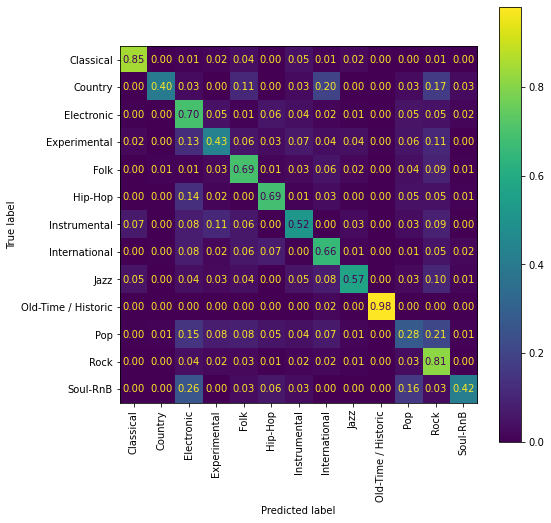

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
scaler = MinMaxScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# now resample the training set

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample all genres < 500 to 500
strategy = {}
for genre, count in Counter(y_train).items():
    if (count < 500):
        strategy[genre] = 500
over = RandomOverSampler(sampling_strategy=strategy, random_state=RANDOM_STATE)
X_train, y_train = over.fit_resample(X_train, y_train)

# undersample all genres > 3500 to 3500
strategy = {}
for genre, count in Counter(y).items():
    if (count > 3500):
        strategy[genre] = 3500
under = RandomUnderSampler(sampling_strategy=strategy, random_state=RANDOM_STATE)
X_train, y_train = under.fit_resample(X_train, y_train)

Counter(y_train)

cl5 = MLPClassifier(alpha=0.01, hidden_layer_sizes=(400,), learning_rate='constant', random_state=RANDOM_STATE)
cl5.fit(X_train, y_train)
utils.run_classifier_and_report(cl5, X_test, y_test)